# Grass growth anomalies

compare SON growth of the previous year with MAM / MAMJJA growth

- Weighted means take into account the number of days in each month

In [1]:
# import libraries
import glob
import importlib
import itertools
import os
import sys
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.plot_configs as cplt
import climag.plot_stats as cstats

In [2]:
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]

In [3]:
importlib.reload(cstats)

<module 'climag.plot_stats' from '/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/climag/plot_stats.py'>

In [36]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.drop_vars([
        "bm_gv", "bm_gr", "bm_dv", "bm_dr", "age_gv", "age_gr", "age_dv",
        "age_dr", "omd_gv", "omd_gr", "lai", "env", "wr", "aet",
        "sen_gv", "sen_gr", "abs_dv", "abs_dr", "i_bm", "h_bm",
        "pgro", "c_bm",  # "bm"
    ])

    return data

In [5]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(
        dataset_dict.values(), combine_attrs="override"
    )
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [6]:
def mean_wgt(ds, months):
    ds_m = ds.sel(time=ds["time"].dt.month.isin(months))

    weights = (
        ds_m["time"].dt.days_in_month.groupby("time.year") /
        ds_m["time"].dt.days_in_month.groupby("time.year").sum()
    )

    # test that the sum of weights for each season is one
    np.testing.assert_allclose(
        weights.groupby("time.year").sum().values,
        np.ones(len(set(weights["year"].values)))
    )

    # calculate the weighted average
    ds_m = (ds_m * weights).groupby("time.year").sum(dim="time")

    return ds_m

In [37]:
def reduce_dataset(dataset):
    ds = {}
    ds_son = {}
    ds_mam = {}
    ds_jja = {}

    for exp, model in itertools.product(exp_list, model_list):
        # auto-rechunking may cause NotImplementedError with object dtype
        # where it will not be able to estimate the size in bytes of object
        # data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds[f"{model}_{exp}"] = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data", "ModVege", dataset, exp, model,
                    f"*{dataset}*{model}*{exp}*.nc"
                )
            ),
            chunks=CHUNKS,
            decode_coords="all"
        )

        # copy CRS
        crs_ds = ds[f"{model}_{exp}"].rio.crs

        # remove spin-up year
        if exp == "historical":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("1976", "2005")
            )
        else:
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("2041", "2070")
            )

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )

        # assign new coordinates and dimensions
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(exp=exp)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="exp")
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(model=model)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="model")

        # calculate cumulative biomass
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign(
            bm_t=(
                ds[f"{model}_{exp}"]["bm"] + ds[f"{model}_{exp}"]["i_bm"] +
                ds[f"{model}_{exp}"]["h_bm"]
            )
        )

        # drop unnecessary variables
        ds[f"{model}_{exp}"] = keep_minimal_vars(data=ds[f"{model}_{exp}"])

        # weighted mean - yearly, SON
        ds_son[f"{model}_{exp}"] = mean_wgt(ds[f"{model}_{exp}"], [9, 10, 11])

        # weighted mean - yearly, MAM
        ds_mam[f"{model}_{exp}"] = mean_wgt(ds[f"{model}_{exp}"], [3, 4, 5])

        # weighted mean - yearly, JJA
        ds_jja[f"{model}_{exp}"] = mean_wgt(ds[f"{model}_{exp}"], [6, 7, 8])

        # ds_son = ds.copy()
        # ds_son[f"{model}_{exp}"] = ds_son[f"{model}_{exp}"].sel(time=ds_son[f"{model}_{exp}"]["time"].dt.month.isin([9, 10, 11]))

        # weights = (
        #     ds_son[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year") /
        #     ds_son[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year").sum()
        # )

        # # test that the sum of weights for each season is one
        # np.testing.assert_allclose(
        #     weights.groupby("time.year").sum().values,
        #     np.ones(len(set(weights["year"].values)))
        # )

        # # calculate the weighted average
        # ds_son[f"{model}_{exp}"] = (
        #     (ds_son[f"{model}_{exp}"] * weights).groupby("time.year").sum(dim="time")
        # )

        # # ensemble mean
        # ds_son[f"{model}_{exp}"] = ds_son[f"{model}_{exp}"].mean(dim="model", skipna=True)

        # # weighted mean - yearly, MAM
        # ds_mam = ds.copy()
        # ds_mam[f"{model}_{exp}"] = ds_mam[f"{model}_{exp}"].sel(time=ds_mam[f"{model}_{exp}"]["time"].dt.month.isin([3, 4, 5]))

        # weights = (
        #     ds_mam[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year") /
        #     ds_mam[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year").sum()
        # )

        # # test that the sum of weights for each season is one
        # np.testing.assert_allclose(
        #     weights.groupby("time.year").sum().values,
        #     np.ones(len(set(weights["year"].values)))
        # )

        # # calculate the weighted average
        # ds_mam[f"{model}_{exp}"] = (
        #     (ds_mam[f"{model}_{exp}"] * weights).groupby("time.year").sum(dim="time")
        # )

        # # ensemble mean
        # ds_mam[f"{model}_{exp}"] = ds_mam[f"{model}_{exp}"].mean(dim="model", skipna=True)

        # # weighted mean - yearly, MAMJJA
        # ds_mamjja = ds.copy()
        # ds_mamjja[f"{model}_{exp}"] = ds_mamjja[f"{model}_{exp}"].sel(time=ds_mamjja[f"{model}_{exp}"]["time"].dt.month.isin([3, 4, 5, 6, 7, 8]))

        # weights = (
        #     ds_mamjja[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year") /
        #     ds_mamjja[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year").sum()
        # )

        # # test that the sum of weights for each season is one
        # np.testing.assert_allclose(
        #     weights.groupby("time.year").sum().values,
        #     np.ones(len(set(weights["year"].values)))
        # )

        # # calculate the weighted average
        # ds_mamjja[f"{model}_{exp}"] = (
        #     (ds_mamjja[f"{model}_{exp}"] * weights).groupby("time.year").sum(dim="time")
        # )

        # # ensemble mean
        # ds_mamjja[f"{model}_{exp}"] = ds_mamjja[f"{model}_{exp}"].mean(dim="model", skipna=True)

        # # weighted mean - yearly
        # weights = (
        #     ds[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year") /
        #     ds[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year").sum()
        # )

        # # test that the sum of weights for each season is one
        # np.testing.assert_allclose(
        #     weights.groupby("time.year").sum().values,
        #     np.ones(len(set(weights["year"].values)))
        # )

        # # calculate the weighted average
        # ds[f"{model}_{exp}"] = (
        #     (ds[f"{model}_{exp}"] * weights).groupby("time.year").sum(dim="time")
        # )

        # # ensemble mean
        # ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].mean(dim="model", skipna=True)

        # # remove spin-up year
        # if exp == "historical":
        #     ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(year=slice("1976", "2005"))
        #     ds_son[f"{model}_{exp}"] = ds_son[f"{model}_{exp}"].sel(year=slice("1976", "2005"))
        # else:
        #     ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(year=slice("2041", "2070"))
        #     ds_son[f"{model}_{exp}"] = ds_son[f"{model}_{exp}"].sel(year=slice("2041", "2070"))

    # combine data
    # ds = combine_datasets(ds, crs_ds)
    ds_son = combine_datasets(ds_son, crs_ds)
    ds_mam = combine_datasets(ds_mam, crs_ds)
    ds_jja = combine_datasets(ds_jja, crs_ds)

    # ensemble mean
    ds_son = ds_son.mean(dim="model", skipna=True)
    ds_mam = ds_mam.mean(dim="model", skipna=True)
    ds_jja = ds_jja.mean(dim="model", skipna=True)

    # shift SON year by one
    ds_son["year"] = ds_son["year"] + 1

    return ds_son, ds_jja, ds_mam

In [44]:
def plot_diff(data, levels, mask=True, plot_var="gro", cmap="BrBG"):
    for exp in list(data["exp"].values):
        print(exp)
        if exp == "historical":
            data_plot = data.sel(year=slice("1976", "2005"))
        else:
            data_plot = data.sel(year=slice("2041", "2070"))
        fig = data_plot.sel(exp=exp)[plot_var].plot.contourf(
            x="rlon", y="rlat", col="year", col_wrap=6,
            subplot_kws={"projection": cplt.plot_projection},
            transform=cplt.rotated_pole_transform(data),
            xlim=(-1.775, 1.6),
            ylim=(-2.1, 2.1),
            figsize=(12, 15.25),
            extend="both", robust=True, cmap="BrBG",
            levels=cstats.colorbar_levels(levels),
            cbar_kwargs = {
                "label": "kg DM ha⁻¹ day⁻¹",
                "aspect": 40,
                "location": "bottom",
                "fraction": 0.085,
                "shrink": 0.85,
                "pad": 0.025,
                "extendfrac": "auto",
                "ticks": cstats.colorbar_ticks(levels)
            }
        )
        for axis in fig.axs.flat:
            if mask:
                mask_layer.to_crs(cplt.plot_projection).plot(
                    ax=axis, color="white", linewidth=0
                )
            cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
                ax=axis, edgecolor="darkslategrey", color="white",
                linewidth=.5
            )
        fig.set_titles("{value}", weight="semibold", fontsize=14)
        plt.show()

In [31]:
# mask out non-pasture areas
mask_layer = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE"
)

## EURO-CORDEX

In [40]:
ds_son, ds_jja, ds_mam = reduce_dataset("EURO-CORDEX")

In [41]:
# ds_son1 = ds_son.copy()
# ds_son1["year"] = ds_son1["year"] - 1

In [42]:
ds_diff1 = ds_mam - ds_son
ds_diff2 = ds_jja - ds_son

historical


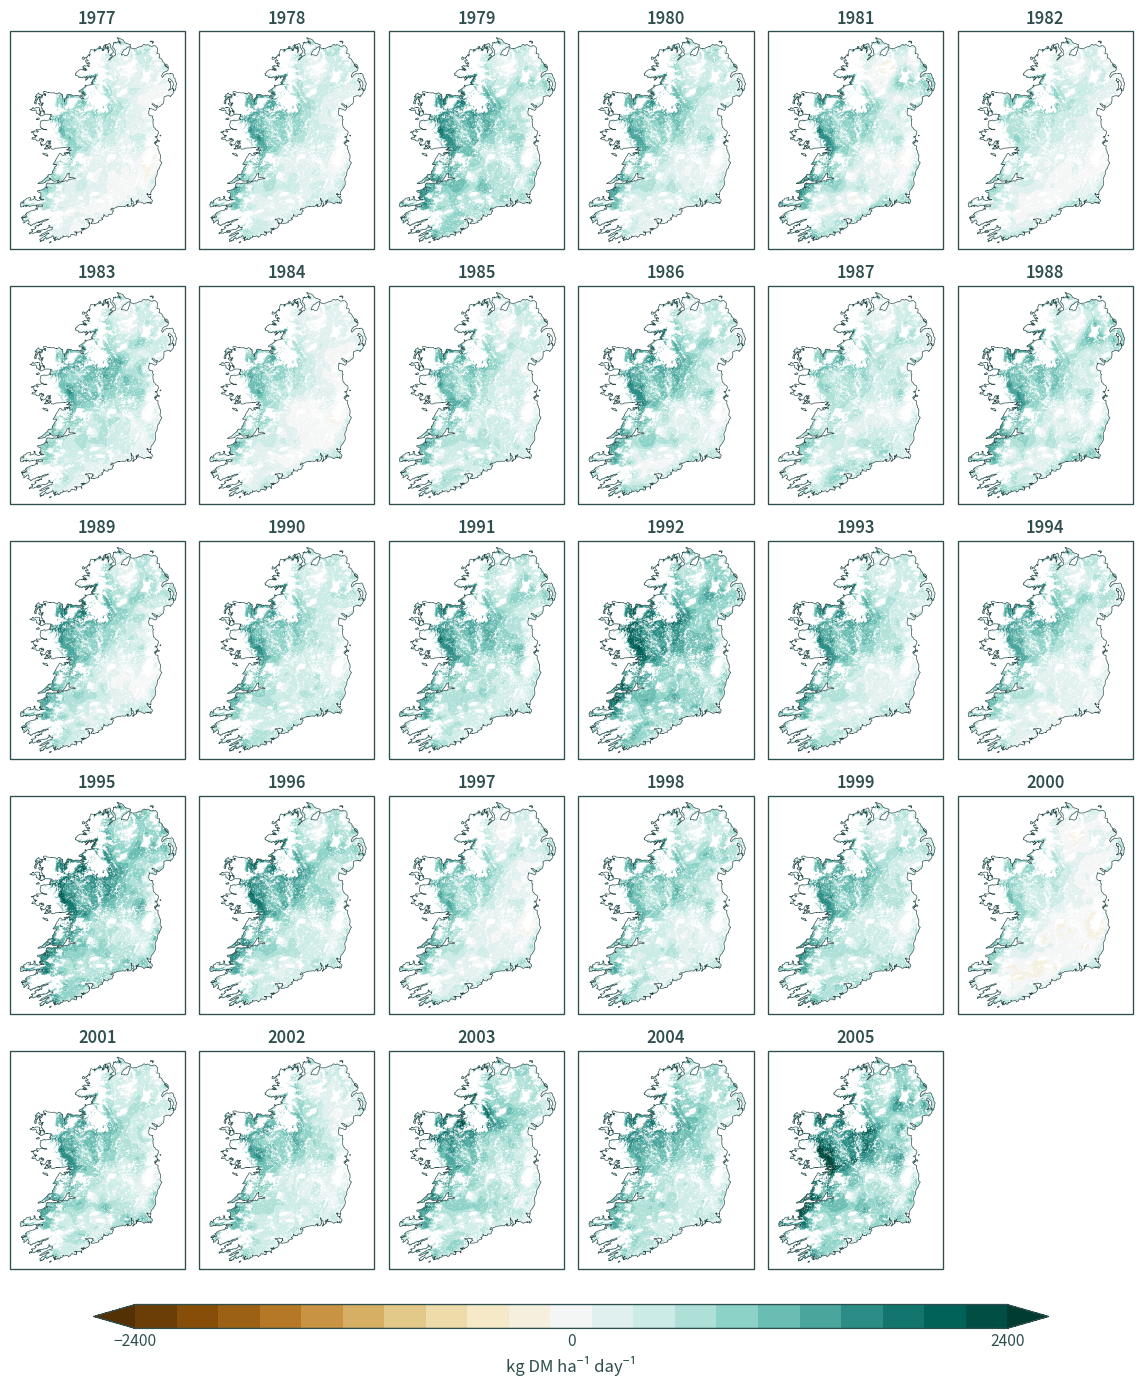

rcp45


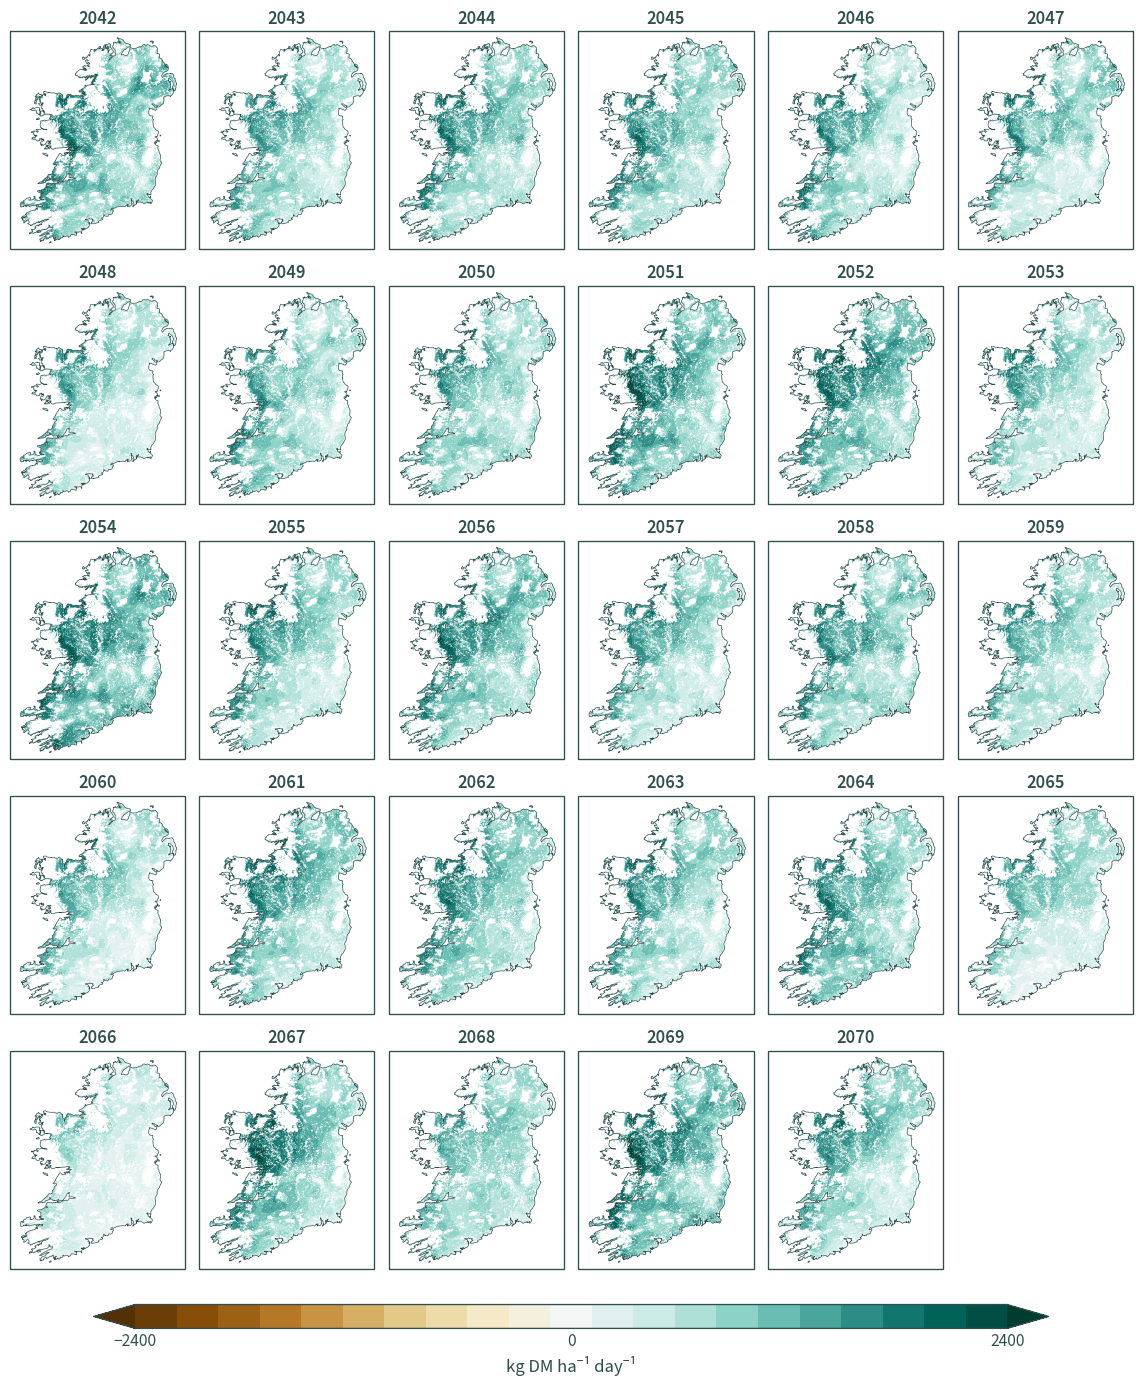

rcp85


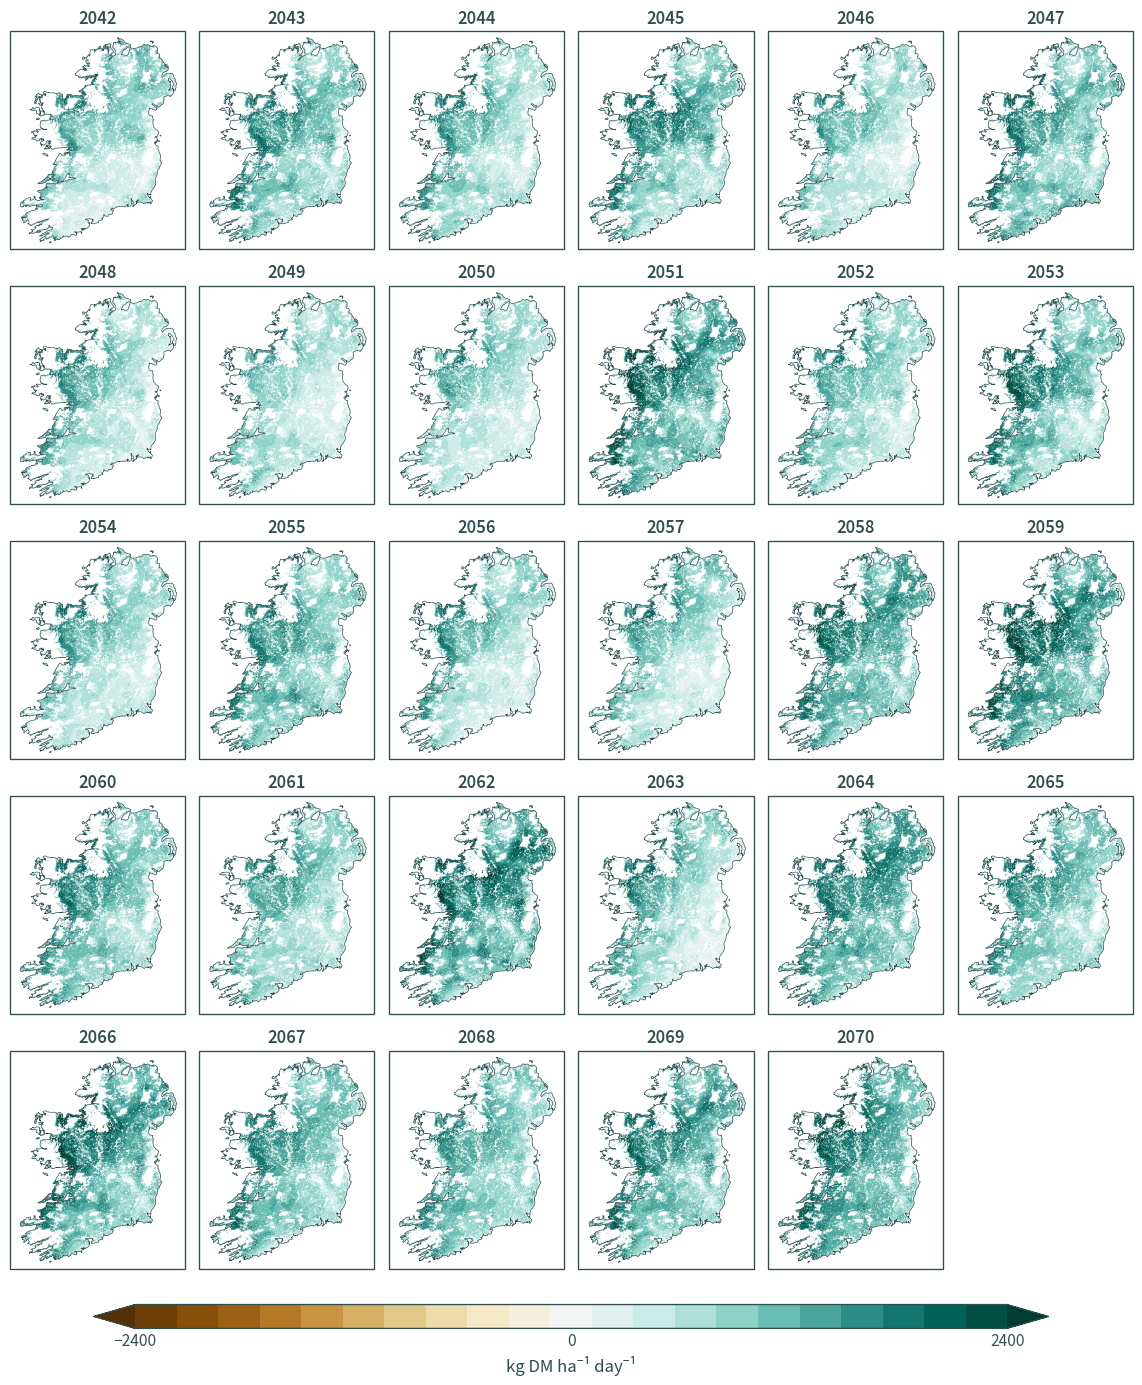

In [45]:
plot_diff(ds_diff2, 2400, plot_var="bm")